In [1]:
import pandas as pd

In [2]:

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
os.chdir('/content/drive/MyDrive/IR-CW/cord')

In [4]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=4c5f796d36f4bf636163a2a58c555223e3b8f0f2c8763edc989e9d405290566b
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence_transformers


In [5]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.4 MB/s eta 0:00:00


## Transformer-based Search Engine

### Search Engine Class:

In [6]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, InputExample
from torch.utils.data import DataLoader
from collections import defaultdict
import random

class SearchEngine:
    def __init__(self, model_name='multi-qa-mpnet-base-dot-v1', 
                 docs_index_path = None, model_path = None, index_dim=768):
        ## Index
        if docs_index_path != None:
            self.index = faiss.read_index(docs_index_path)
        else:
            self.index = faiss.IndexIDMap(faiss.IndexFlatIP(index_dim))
        ## Encoding Model
        if model_path != None:
            self.model = SentenceTransformer(model_path)
        else:
            self.model = SentenceTransformer(model_name)
        ## Encoded documents
        self.test_df = pd.read_csv('docs.csv')
        self.encoded_docs = []
        self.doc2faiss_ids = {}
        for faiss_idx, doc_id in enumerate(self.test_df['doc_id'].tolist()):
            self.doc2faiss_ids[faiss_idx] = doc_id


    def encode_docs(self):
        ## Encoding the docs
        self.encoded_docs = self.model.encode(self.test_df['doc_text'].tolist(), show_progress_bar=True, batch_size=64)
        # self.docs_ids = self.test_df['doc_id'].tolist()

    def add_docs(self):
        ## Indexing encoded docs
        self.index.add_with_ids(self.encoded_docs, np.arange(len(self.doc2faiss_ids)))
        ## Write index to the disk
        faiss.write_index(self.index, 'docs.index')
        print("Indexed Docs Added to disk successfully.")
    
    def generate_candidates(self, query, top_k=10):
        encoded_query = self.model.encode([query])
        top_k_indexes = self.index.search(encoded_query, top_k)
        # print(top_k_indexes)
        top_k_indexes = top_k_indexes[1].tolist()[0]
        top_k_indexes = list(np.unique(top_k_indexes))

        return [self.doc2faiss_ids[faiss_idx] for faiss_idx in top_k_indexes]
    
    def generate_samples(self,train_docs_df, train_querries_df, train_qrels_df):
        rel_label_dict = {0:0.1, 1:0.5, 2:0.9}
        train_qrels_dict = defaultdict(list)
        for query_id, doc_id, relevance in zip(train_qrels_df['query_id'].tolist(), train_qrels_df['doc_id'].tolist(), train_qrels_df['relevance'].tolist()):
            train_qrels_dict[query_id].append(doc_id)

        train_samples = []
        cntr = 0
        for query_id, doc_id, relevance in zip(train_qrels_df['query_id'].tolist(), train_qrels_df['doc_id'].tolist(), train_qrels_df['relevance'].tolist()):
            ## Add sample
            query_text = train_querries_df[train_querries_df['query_id'] == query_id]['query_text'].values[0]
            doc_serie = train_docs_df[train_docs_df['doc_id'] == doc_id]['doc_text']
            if doc_serie.empty == True:
                continue
            doc_text = doc_serie.values[0]

            train_samples.append(
                InputExample(texts=[query_text, doc_text], label=rel_label_dict[relevance])
            )
            if cntr % 1000 == 0:
                print('{} Samples added'.format(cntr))
            cntr += 1

        return train_samples

    
    def fine_tune(self):        
        train_docs_df = pd.read_csv('docs.csv')
        train_querries_df = pd.read_csv('queries.csv')
        train_qrels_df = pd.read_csv('train_dataset/qrels.csv')
        train_samples = self.generate_samples(train_docs_df, train_querries_df, train_qrels_df)

        train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=16)
        train_loss = losses.CosineSimilarityLoss(model=self.model)

        self.model.fit([(train_dataloader, train_loss)], show_progress_bar=True, epochs=2)
        self.model.save('model_save/')
    

### Load Search Engine from the exisiting checkpoint and index:


In [7]:
se = SearchEngine(docs_index_path ='docs.index', model_path = 'model_save/')

## BM25 Search Engine

In [8]:
!pip install rank-bm25

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load the BM25 model and indexed documents:

In [9]:
import pickle

with open('bm25-model.pk1', 'rb') as file:
    bm25_se = pickle.load(file)

## Evaluation & Testing:

In [10]:
test_qrels_dict = defaultdict(list)
test_qrels_df = pd.read_csv('qrels.csv')
for query_id, doc_id, relevance in zip(test_qrels_df['query_id'].tolist(), test_qrels_df['doc_id'].tolist(), test_qrels_df['relevance'].tolist()):
    if relevance != 0:
        test_qrels_dict[query_id].append((doc_id, relevance))

test_qrels_dict_plot = defaultdict(list)
for k,v in test_qrels_dict.items():
    test_qrels_dict_plot[k] = len(v)

### Testing the Search Engine and Plots:

In [11]:
import matplotlib.pyplot as plt
import numpy as np


test_queries_df = pd.read_csv('queries.csv')
test_docs_df = pd.read_csv('docs.csv')
query_ids = np.arange(30)
top_ks = [10, 25, 50, 75, 100, 150, 200]
final_dict_pr = defaultdict(list)
final_dict_re = defaultdict(list)
for top_k in top_ks:
    for query_id in query_ids:
        query_text = test_queries_df[test_queries_df['query_id'] == query_id+1]['query_text'].values[0]
        doc_ids = se.generate_candidates(query_text, top_k=top_k)
        tp = 0
        for ids in doc_ids:
            if ids in [x for x,y in test_qrels_dict[query_id+1]]:
                tp += 1
        pr = tp/top_k
        re = tp/len(test_qrels_dict[query_id+1])
        f1 = 2*(pr*re)/(pr+re)
        final_dict_pr[top_k].append(pr)
        final_dict_re[top_k].append(re)
        # print('Precision:', tp/top_k)
        # print('Recall at {}: {}'.format(top_k, tp/len(test_qrels_dict[query_id])))

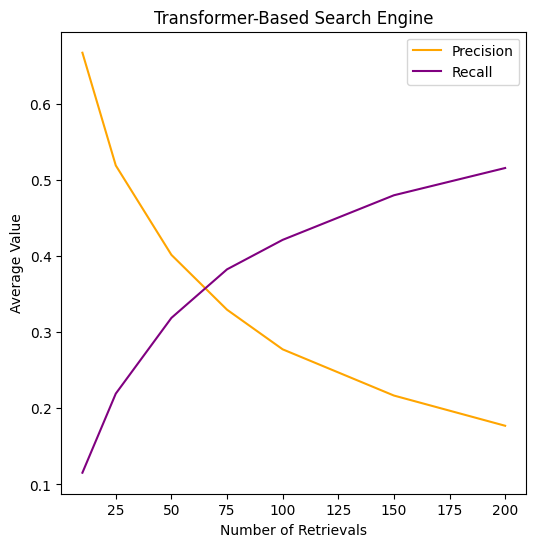

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(final_dict_pr.keys(), [np.mean(v) for v in final_dict_pr.values()], color='orange', label='Precision')
ax.plot(final_dict_re.keys(), [np.mean(v) for v in final_dict_re.values()], color='purple', label='Recall')
ax.set_title('Transformer-Based Search Engine')
ax.set_xlabel('Number of Retrievals')
ax.set_ylabel('Average Value')
ax.legend()
plt.show() 

In [13]:
query_ids = np.arange(30)
top_ks = [10, 25, 50, 75, 100, 150, 200]
final_dict_pr = defaultdict(list)
final_dict_re = defaultdict(list)
docs_list_idx = test_docs_df.doc_id.values.tolist()
for top_k in top_ks:
    for query_id in query_ids:
        query_text = test_queries_df[test_queries_df['query_id'] == query_id+1]['query_text'].values[0]
        tokenized_query = query_text.lower().split(" ")
        doc_ids = bm25_se.get_top_n(tokenized_query, docs_list_idx, n=top_k)

        tp = 0
        for ids in doc_ids:
            if ids in [x for x,y in test_qrels_dict[query_id+1]]:
                tp += 1
        pr = tp/top_k
        re = tp/len(test_qrels_dict[query_id+1])
        final_dict_pr[top_k].append(pr)
        final_dict_re[top_k].append(re)
        # print('Precision:', tp/top_k)
        # print('Recall at {}: {}'.format(top_k, tp/len(test_qrels_dict[query_id])))

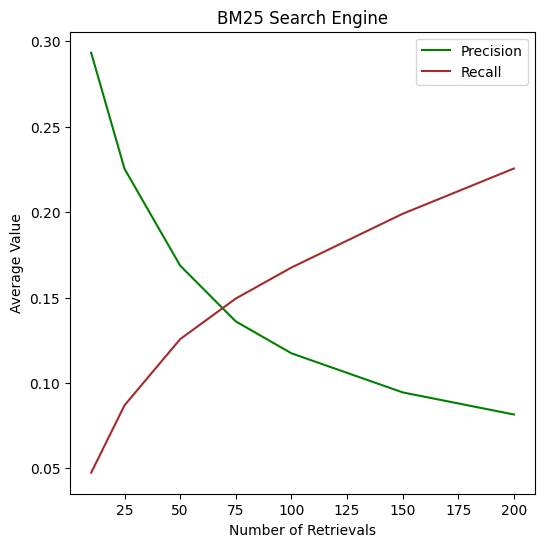

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(final_dict_pr.keys(), [np.mean(v) for v in final_dict_pr.values()], color='green', label='Precision')
ax.plot(final_dict_re.keys(), [np.mean(v) for v in final_dict_re.values()], color='brown', label='Recall')
ax.set_title('BM25 Search Engine')
ax.set_xlabel('Number of Retrievals')
ax.set_ylabel('Average Value')
ax.legend()
plt.show() 

### Testing with Some Sample Queries:

In [15]:
## Function for returning the relevant docs

def return_rel_docs(query_text, top_k, search_engine_type=None, search_engine=None):
    docs_df = pd.read_csv('docs.csv')
    if search_engine_type == 'Transformer':
        doc_ids = search_engine.generate_candidates(query_text, top_k=top_k)

    elif search_engine_type == 'BM25':
        tokenized_query = query_text.lower().split(" ")
        docs_list_idx = docs_df.doc_id.values.tolist()
        doc_ids = bm25_se.get_top_n(tokenized_query, docs_list_idx, n=top_k)

    else:
        return('Invalid Type')
        
    for doc_id in doc_ids:
        print(docs_df[docs_df.doc_id == doc_id].doc_text.values[0])
        print('-'*20)

#### Sample #1:

In [16]:
## Transformer-Based Search Engine ##

query_text = 'source of Corona virus'
return_rel_docs(query_text, top_k=10, search_engine_type='Transformer', search_engine=se)

Bat origin of human coronaviruses. Bats have been recognized as the natural reservoirs of a large variety of viruses. Special attention has been paid to bat coronaviruses as the two emerging coronaviruses which have caused unexpected human disease outbreaks in the 21st century, Severe Acute Respiratory Syndrome Coronavirus (SARS-CoV) and Middle East Respiratory Syndrome Coronavirus (MERS-CoV), are suggested to be originated from bats. Various species of horseshoe bats in China have been found to harbor genetically diverse SARS-like coronaviruses. Some strains are highly similar to SARS-CoV even in the spike protein and are able to use the same receptor as SARS-CoV for cell entry. On the other hand, diverse coronaviruses phylogenetically related to MERS-CoV have been discovered worldwide in a wide range of bat species, some of which can be classified to the same coronavirus species as MERS-CoV. Coronaviruses genetically related to human coronavirus 229E and NL63 have been detected in ba

In [17]:
## BM25 Search Engine ##

return_rel_docs(query_text, top_k=10, search_engine_type='BM25', search_engine=bm25_se)

Analysis on the epidemic factors for the Corona Virus Disease. Since December 2019, corona virus disease 2019 (COVID-19) , an emerging infection disease occurred in Wuhan, has spread in the mainland China. The epidemic factors on the basis of knowledge of SARS-CoV-2 were discussed in this paper. This puts a lot of pressure on clinical resources and care. SARS-CoV-2 is a novel corona virus, the onset of COVID-19 is slow, and the pathogenesis of SARS-CoV-2 remains unclear and may lead to multiple organ damage. These put a lot of pressure on clinical resources and care. Source of infection including the patients, asymptomatic carrier and patients in the incubation period are contagious. It is difficult to control source of infection. Routes of SARS-CoV-2 transmission are diversified and the main routes of transmission for COVID-19 are droplet transmission and close contact transmission. All population have susceptibility to SARS-CoV-2. Social factors such population movements and aggregat

#### Sample #2:

In [18]:
## Transformer-Based Search Engine ##

query_text = 'How can we fight covid?'
return_rel_docs(query_text, top_k=10, search_engine_type='Transformer', search_engine=se)

COVID-19, an emerging coronavirus infection: advances and prospects in designing and developing vaccines, immunotherapeutics, and therapeutics. The novel coronavirus infection (COVID-19 or Coronavirus disease 2019) that emerged from Wuhan, Hubei province of China has spread to many countries worldwide. Efforts have been made to develop vaccines against human coronavirus (CoV) infections such as MERS and SARS in the past decades. However, to date, no licensed antiviral treatment or vaccine exists for MERS and SARS. Most of the efforts for developing CoV vaccines and drugs target the spike glycoprotein or S protein, the major inducer of neutralizing antibodies. Although a few candidates have shown efficacy in in vitro studies, not many have progressed to randomized animal or human trials, hence may have limited use to counter COVID-19 infection. This article highlights ongoing advances in designing vaccines and therapeutics to counter COVID-19 while also focusing on such experiences and 

In [19]:
## BM25 Search Engine ##

return_rel_docs(query_text, top_k=10, search_engine_type='BM25', search_engine=bm25_se)

How monkeys, mice and ferrets are helping scientists to fight coronavirus. 
--------------------
SARS-CoV-2 outbreak: How can pharmacists help?. Abstract Coronaviruses (CoVs) are a large family of viruses that cause disorders ranging from a mild cold to severe disease. Some of the CoVs are zoonotic, meaning they can be transmitted from animals to humans. In December 2019, the world awoke to a new zoonotic strain of CoV that was named SARS-CoV-2 (standing for severe acute respiratory syndrome coronavirus 2), which has been classified as a high-consequence infectious disease. In addition, serious complications related to COVID-19 have been reported in some patients. These include acute respiratory distress syndrome, acute renal failure, septic shock and ventilator-associated pneumonia. The pharmacist, as a healthcare practitioner, can play an important role in hindering the spread of COVID-19, and can be an active participant in national and community efforts to fight and contain this ou

#### Sample #3:

In [20]:
## Transformer-Based Search Engine ##

query_text = 'Danger of covid'
return_rel_docs(query_text, top_k=10, search_engine_type='Transformer', search_engine=se)

Risks of Death and Severe Disease in Patients With Middle East Respiratory Syndrome Coronavirus, 2012–2015. Middle East respiratory syndrome coronavirus (MERS-CoV) is an emerging pathogen, first recognized in 2012, with a high case fatality risk, no vaccine, and no treatment beyond supportive care. We estimated the relative risks of death and severe disease among MERS-CoV patients in the Middle East between 2012 and 2015 for several risk factors, using Poisson regression with robust variance and a bootstrap-based expectation maximization algorithm to handle extensive missing data. Increased age and underlying comorbidity were risk factors for both death and severe disease, while cases arising in Saudi Arabia were more likely to be severe. Cases occurring later in the emergence of MERS-CoV and among health-care workers were less serious. This study represents an attempt to estimate risk factors for an emerging infectious disease using open data and to address some of the uncertainty sur

In [21]:
## BM25 Search Engine ##

return_rel_docs(query_text, top_k=10, search_engine_type='BM25', search_engine=bm25_se)

Covid 19 pandemic and gynaecological laparoscopic surgery: knowns and unknowns. The worldwide impact of COVID 19 continues to be felt as hospitals in all countries reduce elective and non-urgent cases to allow staffing and resources to be deployed elsewhere. Urgent gynaecological and cancer procedures are continuing, and it is imperative all theatre staff are protected and risks of SARS-CoV-2 viral transmission reduced when operating on asymptomatic, suspected or confirmed COVID 19 patients. In particular, there are concerns relating to the transmission of COVID 19 during gynaecological laparoscopic surgery, arising from the potential generation of SARS-CoV-2 contaminated aerosols from CO(2) leakage and the creation of smoke from the use of energy devices. The aim of this paper is to review all the up to date evidence, including experiences from China and Italy, to guide the safe management of such patients when undergoing gynaecological procedures.
--------------------
COVID 19 and In

#### Sample #4:

In [22]:
## Transformer-Based Search Engine ##

query_text = 'Is Covid dangerous?'
return_rel_docs(query_text, top_k=10, search_engine_type='Transformer', search_engine=se)

Risks of Death and Severe Disease in Patients With Middle East Respiratory Syndrome Coronavirus, 2012–2015. Middle East respiratory syndrome coronavirus (MERS-CoV) is an emerging pathogen, first recognized in 2012, with a high case fatality risk, no vaccine, and no treatment beyond supportive care. We estimated the relative risks of death and severe disease among MERS-CoV patients in the Middle East between 2012 and 2015 for several risk factors, using Poisson regression with robust variance and a bootstrap-based expectation maximization algorithm to handle extensive missing data. Increased age and underlying comorbidity were risk factors for both death and severe disease, while cases arising in Saudi Arabia were more likely to be severe. Cases occurring later in the emergence of MERS-CoV and among health-care workers were less serious. This study represents an attempt to estimate risk factors for an emerging infectious disease using open data and to address some of the uncertainty sur

In [23]:
## BM25 Search Engine ##

return_rel_docs(query_text, top_k=10, search_engine_type='BM25', search_engine=bm25_se)

Covid 19 pandemic and gynaecological laparoscopic surgery: knowns and unknowns. The worldwide impact of COVID 19 continues to be felt as hospitals in all countries reduce elective and non-urgent cases to allow staffing and resources to be deployed elsewhere. Urgent gynaecological and cancer procedures are continuing, and it is imperative all theatre staff are protected and risks of SARS-CoV-2 viral transmission reduced when operating on asymptomatic, suspected or confirmed COVID 19 patients. In particular, there are concerns relating to the transmission of COVID 19 during gynaecological laparoscopic surgery, arising from the potential generation of SARS-CoV-2 contaminated aerosols from CO(2) leakage and the creation of smoke from the use of energy devices. The aim of this paper is to review all the up to date evidence, including experiences from China and Italy, to guide the safe management of such patients when undergoing gynaecological procedures.
--------------------
Frequency of te

#### Sample #5:

In [24]:
## Transformer-Based Search Engine ##

query_text = 'Symptoms of Covid'
return_rel_docs(query_text, top_k=10, search_engine_type='Transformer', search_engine=se)

Epidemiological, clinical and virological characteristics of 74 cases of coronavirus-infected disease 2019 (COVID-19) with gastrointestinal symptoms. OBJECTIVE: The SARS-CoV-2-infected disease (COVID-19) outbreak is a major threat to human beings. Previous studies mainly focused on Wuhan and typical symptoms. We analysed 74 confirmed COVID-19 cases with GI symptoms in the Zhejiang province to determine epidemiological, clinical and virological characteristics. DESIGN: COVID-19 hospital patients were admitted in the Zhejiang province from 17 January 2020 to 8 February 2020. Epidemiological, demographic, clinical, laboratory, management and outcome data of patients with GI symptoms were analysed using multivariate analysis for risk of severe/critical type. Bioinformatics were used to analyse features of SARS-CoV-2 from Zhejiang province. RESULTS: Among enrolled 651 patients, 74 (11.4%) presented with at least one GI symptom (nausea, vomiting or diarrhoea), average age of 46.14 years, 4-d

In [25]:
## BM25 Search Engine ##

return_rel_docs(query_text, top_k=10, search_engine_type='BM25', search_engine=bm25_se)

COVID 19 and Intra cerebral hemorrhage: Causative or Coincidental. Abstract Pneumonia appears to be the most manifestation of COVID 19, but some extra-pulmonary involvement such as gastrointestinal, cardiac and renal has been reported. According to limited clinical data about the virus behavior up to now, specially extra-pulmonary symptoms, we should be aware on possibility of initial cerebrovascular manifestations of COVID19.
--------------------
Geo temporal distribution of 1,688 Chinese healthcare workers infected with COVID-19 in severe conditions, a secondary data analysis. Introduction The COVID 19 outbreak is posing an unprecedented challenge to healthcare workers. This study analyzes the geo temporal effects on disease severity for the 1,688 Chinese healthcare workers infected with COVID 19. Method Using the descriptive results recently reported by the Chinese CDC, we compare the percentage of infected healthcare workers in severe conditions over time and across three areas in 

#### Sample #6:

In [26]:
## Transformer-Based Search Engine ##

query_text = 'Covid treatment'
return_rel_docs(query_text, top_k=10, search_engine_type='Transformer', search_engine=se)

A novel treatment approach to the novel coronavirus: an argument for the use of therapeutic plasma exchange for fulminant COVID-19. 
--------------------
Covid-19 — The Search for Effective Therapy. 
--------------------
Emerging Therapeutic Strategies for COVID-19 patients. Over 100,000 cases of COVID-19 patients infected with the novel coronavirus SARS-COV-2 have been reported worldwide in approximately 2 months, resulting in over 3000 deaths. Potential therapeutic strategies, including remdesivir, chloroquine phosphate, abidol, lopinavir/ritonavir, plasma, antibody, vaccine and stem cells are discussed in this review. With the number of patients increasing daily, there is an urgent need for effective therapeutic intervention.
--------------------
Teicoplanin: an alternative drug for the treatment of COVID-19?. ABSTRACT In December 2019, a novel coronavirus, named severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), emerged from China causing pneumonia outbreaks, first in th

In [27]:
## BM25 Search Engine ##

return_rel_docs(query_text, top_k=10, search_engine_type='BM25', search_engine=bm25_se)

Effect of continuous renal replacement therapy on all-cause mortality in COVID-19 patients undergoing invasive mechanical ventilation: a retrospective cohort study. Background: Since December 2019, when coronavirus disease 2019 (COVID 19) emerged in Wuhan and rapidly spread throughout the world, critically ill patients have a high mortality rate. We aimed to assess the effect of continuous renal replacement therapy (CRRT) on all cause mortality in patients with COVID 19 undergoing invasive mechanical ventilation. Methods: In this retrospective cohort study, we included all patients with COVID 19 undergoing invasive mechanical ventilation at Optical Valley Branch of Tongji Hospital Affiliated with Tongji Medical College, Huazhong University of Science and Technology, Wuhan from February 12th to March 2nd, 2020. Demographic, clinical, laboratory, and treatment data were collected and analyzed. All patients were followed until death or end of follow up (March 9th), and all survivors were 